# PART III: Qiskit 101

### Overview

1. Quantum circuits and visualization
2. Running on real backends
3. Hands-on exercises

## 1. Quantum circuits and visualization

### Building your first quantum circuit

As a first "hello-world" example, we will build and simulate a Bell circuit, showcasing the basic workflow of Qiskit. 

In [ ]:
from qiskit import QuantumCircuit

# Create circuit
circuit = QuantumCircuit(2)
circuit.h(0)
circuit.cx(0, 1)
circuit.draw('mpl',initial_state=True)

### Simulating the final state
In many situations you want to see the final state of a quantum circuit. We can simulate the Statevector prepared by a quantum circuit with the `statevector_simulator` backend.

In [ ]:
from qiskit.visualization import array_to_latex
from qiskit import Aer

qc = QuantumCircuit(2)
qc.x(0)
qc.h(0)
qc.cx(0, 1)
backend = Aer.get_backend('statevector_simulator') # the device to run on
result = backend.run(qc).result()
psi = result.get_statevector(qc)
array_to_latex(psi)

### Plotting the state

There are several functions for generating different types of visualization of a quantum state

In [ ]:
from qiskit.visualization import plot_state_qsphere

plot_state_qsphere(psi)

In [ ]:
from qiskit.visualization import plot_state_city

plot_state_city(psi)

In [ ]:
from qiskit.visualization import plot_state_hinton

plot_state_hinton(psi)

In [ ]:
from qiskit.visualization import plot_state_paulivec

plot_state_paulivec(psi)

### Executing the circuit

Before executing the circuit, we need to add a measurement.

In [ ]:
circuit.measure_all()

circuit.draw('mpl')

To execute a circuit, we need to choose a backend. Here we use a basic simulator from qiskit Aer. 

In [ ]:
backend = Aer.get_backend('aer_simulator')  # this is the simulator we'll use
job = backend.run(circuit) # this runs the experiment

result = job.result()
counts = result.get_counts()
print(counts)

We can then plot the results in a histogram.

In [ ]:
from qiskit.visualization import plot_histogram

plot_histogram(counts)

## 2. Running on real backends

### Circuit transpilation

Backends in Qiskit are accessed through a `provider`.

In [ ]:
from qiskit import IBMQ

#IBMQ.save_account(TOKEN, HUB, GROUP, PROJECT)
provider = IBMQ.load_account() # Loading your IBM Quantum account(s)
provider = IBMQ.get_provider(hub='ibm-q-education', group='eth-zurich-ibm-1', project='cern-workshop')

With the IBM education provider, these are the devices we can access:

In [ ]:
[(b.name(), b.configuration().n_qubits) for b in provider.backends()]

In [ ]:
from qiskit.providers.ibmq import least_busy

# get least busy device backend with > 2 qubits
backend = least_busy(provider.backends(
                simulator=False,
                filters=lambda b: b.configuration().n_qubits >= 3))
backend

In [ ]:
# run on least busy backend
backend =  provider.get_backend('ibm_lagos')
job = backend.run(circuit)

In [ ]:
# get results
job.result()

This fails, because the circuit needs to be _transpiled_ to the backend, i.e., decomposed into operations which the backend can implement. 

In [ ]:
from qiskit import transpile

# transpile with specified backend
transpiled_circuit = transpile(circuit, backend, optimization_level=3)
transpiled_circuit.draw('mpl', idle_wires=False)

In [ ]:
from qiskit.visualization import plot_circuit_layout, plot_gate_map
display(plot_gate_map(backend), plot_circuit_layout(transpiled_circuit, backend))

In [ ]:
import qiskit.tools.jupyter
%qiskit_job_watcher
# this will run the job on the backend
job = backend.run(transpiled_circuit, shots = 2000)

print(job.job_id())

In [ ]:
# get results
provider = IBMQ.get_provider(hub='ibm-q-education', group='eth-zurich-ibm-1', project='summer-school-qi')
backend =  provider.get_backend('ibm_lagos')
job = backend.retrieve_job('6316774d76e4d161a20b4267')
result = job.result()
counts = result.get_counts()
plot_histogram(counts)

## 3. Hands-on Exercises

Please go to **bit.ly/3Uol42R** and try to solve exercise sheets 1 (circuits) & 2 (advanced circuits)

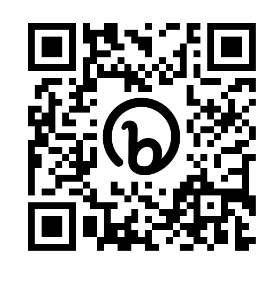

# PART IV: Grover's Algorithm

Solves unstructured search problems, e.g. searching an unsorted database with $N=2^n$ elements

Classical computer needs $N/2 = \mathcal{O}(N)$ time, quantum computer $\mathcal{O}(\sqrt{N})$

### Amplitude Amplification
1. Put all items in superposition
2. Apply phase oracle $\tilde{U}_f$
3. Apply diffuser: perform reflection around average amplitude
#### Circuit representation:
<img src="Grovers.png" alt="Drawing" style="width: 580px;"/>

### Amplitude Amplification
<font size="5"> 
    1. Put all items in superposition <br>
    2. Apply phase oracle: flips sign of „winning element“ $|w\rangle$  <br>
    3. Apply diffuser: performs reflection around average amplitude <br>
Repeat 2. & 3. $r$ times $\rightarrow$ final measurement will result in $|w\rangle$ with very high probability.
</font>
<img src="amplitudeamplification.png" alt="Drawing" style="width: 520px;"/>

### Self-made oracle & algorithm
Let us start by creating our own phase oracle function and diffuser function.

In [ ]:
from qiskit.quantum_info import Operator

def phase_oracle(n, indices_to_mark, name = 'Oracle'):
    qc = QuantumCircuit(n, name=name)
    oracle_matrix = np.identity(2**n)
    for index_to_mark in indices_to_mark:
        oracle_matrix[index_to_mark, index_to_mark] = -1
    qc.unitary(Operator(oracle_matrix), range(n))
    return qc

def diffuser(n):
    qc = QuantumCircuit(n, name='Diff - "V"')
    qc.h(range(n))
    qc.append(phase_oracle(n,[0]),range(n))
    qc.h(range(n))
    return qc

Now we can combine these to build our Grover algorithm:

In [ ]:
def Grover(n, marked):
    qc = QuantumCircuit(n, n)
    r = int(np.round(np.pi/(4*np.arcsin(np.sqrt(len(marked)/2**n)))-1/2))
    print(f'{n} qubits, basis state {marked} marked, {r} rounds')
    qc.h(range(n))
    for _ in range(r):
        qc.append(phase_oracle(n,marked), range(n))
        qc.append(diffuser(n), range(n))
    qc.measure(range(n), range(n))
    return qc

In [ ]:
import numpy as np

n = 5
x = np.random.randint(2**n)
marked = [x]
qc = Grover(n, marked)

qc.draw('mpl')

In [ ]:
from qiskit import execute 

backend = Aer.get_backend('qasm_simulator')
result = execute(qc, backend, shots=10000).result()
counts = result.get_counts(qc)
print(counts)
plot_histogram(counts)

In [ ]:
def Grover_run_roundwise(n, marked):
    r = int(np.round(np.pi/(4*np.arcsin(np.sqrt(len(marked)/2**n)))-1/2))
    print(f'{n} qubits, basis state {marked} marked, {r} rounds')
    counts = []
    for i in range(r):
        qc = QuantumCircuit(n, n)
        qc.h(range(n))
        for _ in range(i+1):
            qc.append(phase_oracle(n,marked), range(n))
            qc.append(diffuser(n), range(n))
        qc.measure(range(n), range(n))
        result = execute(qc, backend, shots=10000).result()
        counts.append(result.get_counts(qc))
    return counts

backend = Aer.get_backend('qasm_simulator')
counts = Grover_run_roundwise(n,marked)

In [ ]:
plot_histogram(counts[0])

In [ ]:
print(counts[3])
plot_histogram(counts, bar_labels=False)

In [ ]:
n = 3
x = np.random.randint(2**n)
y = np.random.randint(2**n)
while y==x:
    y = np.random.randint(2**n)
marked = [x,y]
qc = Grover(n, marked)

provider = IBMQ.get_provider(hub='ibm-q-internal', group='deployed', project='default')
#backend = provider.get_backend('ibm_hanoi')
backend = least_busy(provider.backends(filters=lambda x: x.configuration().n_qubits >= n and
                                   not x.configuration().simulator and x.status().operational==True))
print("least busy backend: ", backend)

shots = 20000
#layout = [1,2,4] #hanoi
job = execute(qc, backend=backend, shots=shots, optimization_level=3)
#job = execute(qc, backend=backend, shots=shots, initial_layout=layout, optimization_level=3)
print(job.job_id())

In [ ]:
# job status
job.status()

In [ ]:
# Get the results of the computation
results = job.result()
answer = results.get_counts()
plot_histogram(answer)

In [ ]:
# job I ran before
provider = IBMQ.get_provider(hub='ibm-q-internal', group='deployed', project='default')
backend = provider.get_backend('ibm_hanoi')
old_job = backend.retrieve_job('629c83c022557e3921649245')
results = old_job.result()
answer = results.get_counts()
plot_histogram(answer)

### Grover's Algorithm to Solve a Satisfyability Problem
Imagine you are throwing a birthday party and you need to decide which of your friends Alice, Bob, Charlie, Dave and Eve to invite. There are a few restrictions:
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>

### Grover's Algorithm to Solve a Satisfyability Problem
Imagine you are throwing a birthday party and you need to decide which of your friends Alice, Bob, Charlie, Dave and Eve to invite. There are a few restrictions:

i) Alice and Eve are always fighting, so you definitely do not want to invite both of them.
<br>
<br>
<br>
<br>
<br>
<br>

### Grover's Algorithm to Solve a Satisfyability Problem
Imagine you are throwing a birthday party and you need to decide which of your friends Alice, Bob, Charlie, Dave and Eve to invite. There are a few restrictions:

i) Alice and Eve are always fighting, so you definitely do not want to invite both of them.

ii) Alice and Charlie are married, so if you invite one of them, you have to invite the other one as well.
<br>
<br>
<br>
<br>

### Grover's Algorithm to Solve a Satisfyability Problem
Imagine you are throwing a birthday party and you need to decide which of your friends Alice, Bob, Charlie, Dave and Eve to invite. There are a few restrictions:

i) Alice and Eve are always fighting, so you definitely do not want to invite both of them.

ii) Alice and Charlie are married, so if you invite one of them, you have to invite the other one as well.

iii) In order to liven up the atmosphere, you want to invite at least one of your more entertaining friends, Bob and Dave.

iv) Whenever the three guys, Bob, Charlie and Dave, get together, they somehow incite each other and the party might get out of control. So don't invite all three of them.

v) You know that if you invite Bob, he will most likely ask Alice about ideas for a birthday present. Therefore, if you invite Bob, you should also invite Alice (but not necessarily the other way around).

vi) Dave will only come if Bob comes as well (not the other way around though). So no point to invite him if Bob is not getting invited.

Let us use Grover's algorithm to figure out which options you have for possible invite lists. To feed these requirements into the oracle, let us encode them as logical statements and then formulate them as a 3-SAT problem. 

Note that 3-SAT problems can be always written in what is known as conjunctive normal form (CNF), which is a conjunction of clauses (or a single clause). Each clause in the 3-SAT problem is a disjunction ("or") of at most three literals. A literal is either a variable, called positive literal, or the negation of a variable, called negative literal.

To give you an example, the first statement could be encoded as a logical statement as $\lnot (A \land E)$. 

However, this is not a clause (or a conjunction of clauses). We can rewrite it as $\lnot A \lor \lnot E$
though, which is a disjunction of two negative literals and therefore a valid clause.

For the input to the oracle in Qiskit, we encode each clause as one line with the literals and a "0" in the end, so in this case the corresponding line would be (encoding A as 1, B as 2, C as 3, D as 4 and E as 5),

-1 -5 0

Writing each of the restrictions as a clause or a conjunction of clauses, we get for the six restrictions the following seven clauses as ii) cannot be written as a single clause:

i) $\quad \lnot A \lor \lnot E \qquad$ -1 -5 0

ii) $\quad (A \lor \lnot C) \land (\lnot A \lor C) \qquad$ 1 -3 0 $\land$ -1 3 0

iii) $\quad B \lor D \qquad$ 2 4 0

iv) $\quad \lnot B \lor \lnot C \lor \lnot D \qquad$ -2 -3 -4 0

v) $\quad A \lor \lnot B \qquad$ 1 -2 0

vi) $\quad B \lor \lnot D \qquad$ 2 -4 0

In [ ]:
from qiskit.circuit.library import PhaseOracle

# this indicates that the input is CNF with five variables and seven clauses
input_3sat = '''
c example DIMACS-CNF 3-SAT
p cnf 5 7 
-1 -5 0
1 -3 0
-1 3 0
2 4 0
-2 -3 -4 0
1 -2 0
2 -4 0
'''

with open("3sat.dimacs", "w") as text_file:
    text_file.write(input_3sat)

oracle = PhaseOracle.from_dimacs_file("3sat.dimacs")

In [ ]:
from qiskit.algorithms import Grover, AmplificationProblem
from qiskit.utils import QuantumInstance

backend = Aer.get_backend('aer_simulator')
quantum_instance = QuantumInstance(backend, shots=1024)
problem = AmplificationProblem(oracle=oracle)

# Use Grover's algorithm to solve the problem
grover = Grover(quantum_instance=quantum_instance)
result = grover.amplify(problem)
result.top_measurement

In [ ]:
plot_histogram(result.circuit_results)

In [ ]:
# transpile the circuit for our backend
qc = grover.construct_circuit(problem, max(result.iterations))
qc.measure_all()
backend = provider.get_backend('ibm_hanoi')
grover_compiled = transpile(qc, backend=backend, optimization_level=3)

print('gates = ', grover_compiled.count_ops())
print('depth = ', grover_compiled.depth())

Unfortunately, the number of gates needed is above the limits regarding decoherence time of the current near-term quantum computers. Thus, for now we will stick to the simulations ;-)

# PART V: Noisy backends and measurement error mitigation

Present day quantum computers are subject to noise of various kinds. The principle behind error mitigation is to reduce the effects from a specific source of error by classically post-processing the counts. Here we will look at mitigating measurement errors.

### Measurement error mitigation
We start by creating a set of circuits that prepare and measure each of the $2^n$ basis states, where $n$ is the number of qubits. The outcome statistics are then captured by a calibration matrix $M$, where the element $M_{ij}$ gives the probability to get output state $|i\rangle$ when state $|j\rangle$ was prepared. 

In [ ]:
from qiskit.utils.mitigation import complete_meas_cal, CompleteMeasFitter

n=3
meas_calibs, state_labels = complete_meas_cal(range(n), circlabel='mcal')

Next, we need to choose our device:

In [ ]:
from qiskit import IBMQ, execute

# IBMQ.save_account(TOKEN) # needed only for the first time
provider = IBMQ.load_account() # load your IBM Quantum Experience account
provider = IBMQ.get_provider(hub='ibm-q-education', group='eth-zurich-ibm-1', project='cern-workshop')

In [ ]:
[(b.name(), b.configuration().n_qubits) for b in provider.backends()]

Since I have reserved ``ibm_nairobi``, ``ibm_perth`` and ``ibmq_jakarta`` for the next two hours, I'd recommend choosing one of those for now.

In [ ]:
backend = provider.get_backend('ibm_nairobi')

Now we run these calibration circuits on our real device! 

In [ ]:
import qiskit.tools.jupyter
%qiskit_job_watcher

shots = 10000
layout = [4,5,6]
cal_job = execute(meas_calibs, backend=backend, initial_layout=layout, shots=shots)
print(cal_job.job_id())

In [ ]:
from qiskit.visualization import array_to_latex

provider = IBMQ.get_provider(hub='ibm-q-internal', group='deployed', project='default')
backend = provider.get_backend('ibm_geneva')
cal_job = backend.retrieve_job('63166f48b11a631bd2591e62') # cal job I ran before
cal_results = cal_job.result()
meas_fitter = CompleteMeasFitter(cal_results, state_labels, circlabel='mcal')
meas_filter = meas_fitter.filter
array_to_latex(meas_fitter.cal_matrix)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def plot_calibration(self, cal_index=0, ax=None, show_plot=True):
    if ax is None:
        plt.figure()
        ax = plt.gca()
    axim = ax.matshow(self.cal_matrix, cmap=plt.cm.binary, clim=[0, 1])
    ax.figure.colorbar(axim)
    ax.set_xlabel('Prepared State')
    ax.xaxis.set_label_position('top')
    ax.set_ylabel('Measured State')
    ax.set_xticks(np.arange(len(self.state_labels)))
    ax.set_yticks(np.arange(len(self.state_labels)))
    ax.set_xticklabels(self.state_labels)
    ax.set_yticklabels(self.state_labels)

    if show_plot:
        plt.show()

In [ ]:
plot_calibration(meas_fitter)

Note that the calibration matrix is in general not invertible, thus requiring a generalized inverse method to solve.  Additionally, the noise is not deterministic, and has fluctuations, so this will in general not give you the ideal noise-free state, but it should bring you closer to it.

In [ ]:
cal_job = backend.retrieve_job('631672ab76f8e34d9f95d63c')
cal_results = cal_job.result()
meas_fitter = CompleteMeasFitter(cal_results, state_labels, circlabel='mcal')
plot_calibration(meas_fitter)

In [ ]:
from qiskit import QuantumCircuit, transpile

# GHZ state
n = 3
qc = QuantumCircuit(n, n)
qc.h(1)
qc.cx(1, 0)
qc.cx(1, 2)
qc.measure(range(n), range(n))
t_qc = transpile(qc, backend, initial_layout=[5,8,9], optimization_level=3)

In [ ]:
job = backend.run(t_qc)

print(job.job_id())

In [ ]:
from qiskit.tools.visualization import plot_histogram

# GHZ job I ran before
old_job = backend.retrieve_job('6316807243edaa475aed16e8')
results = old_job.result()
noisy_counts = results.get_counts()
mitigated_results = meas_filter.apply(results)
mitigated_counts = mitigated_results.get_counts(0)
plot_histogram([noisy_counts, mitigated_counts], legend=['noisy', 'mitigated'])

In [ ]:
# Grover job I ran before
backend = provider.get_backend('ibm_hanoi')
old_job = backend.retrieve_job('629c83c022557e3921649245')
results = old_job.result()
noisy_counts = results.get_counts(0)
cal_job = backend.retrieve_job('629c818101885c7622f35a8e') # cal job I ran before
cal_results = cal_job.result()
meas_filter = CompleteMeasFitter(cal_results, state_labels, circlabel='mcal').filter
mitigated_results = meas_filter.apply(results)
mitigated_counts = mitigated_results.get_counts(0)
plot_histogram([noisy_counts, mitigated_counts], legend=['noisy', 'mitigated'])

### Device backend noise model simulations

We have already used the basic ``AerSimulator`` backend to simulate our noise-free results. We will now show how to use the Qiskit Aer noise model, which is generated using the calibration information reported in the ``BackendProperties`` of a device and takes into account

* The gate_error probability of each basis gate on each qubit.
* The gate_length of each basis gate on each qubit.
* The T1, T2 relaxation time constants of each qubit.
* The readout error probability of each qubit.

Let us use the real noise data of ```ibm_nairobi```:

In [ ]:
from qiskit.providers.aer import AerSimulator
from qiskit.providers.fake_provider import FakeNairobi
fake_backend = FakeNairobi()

# Create simulator from backend 
sim_nairobi = AerSimulator.from_backend(fake_backend)

Once we have created a noisy simulator backend based on a real device we can use it to run noisy simulations.

In [ ]:
# Transpile the circuit for the noisy basis gates and get results
t_qc = transpile(qc, sim_nairobi)
result_noise = sim_nairobi.run(t_qc, layout = [0,1,2]).result()
counts_sim_noise = result_noise.get_counts(0)

# Compare to ideal simulator
sim_ideal = AerSimulator()
result = sim_ideal.run(transpile(qc, sim_ideal)).result()
counts = result.get_counts(0)

# Compare to actual noisy results
provider = IBMQ.get_provider(hub='ibm-q-education', group='eth-zurich-ibm-1', project='summer-school-qi')
backend = provider.get_backend('ibm_nairobi')
old_job = backend.retrieve_job('63174d7043edaa9cf6ed1b06') #[0,1,2]
noisy_counts = old_job.result().get_counts(0)

In [ ]:
plot_histogram([counts, counts_sim_noise, noisy_counts], legend=['ideal', 'noisy_sim', 'noisy'], title="Counts for 3-qubit GHZ state with device noise model")

## Hands-on Exercises

Please go to **bit.ly/3Uol42R** and try to solve exercise sheets 3 (real devices) & 4 (measurement error mitigation)

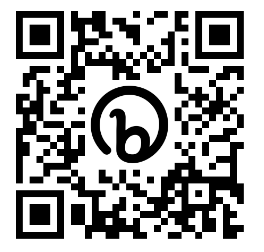

In [ ]:
import qiskit.tools.jupyter
%qiskit_version_table